In [1]:
# Import necessary libraries
# === 1. Imports & Seeds ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, utils
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Dataset configuration
IMG_SIZE = 227  # AlexNet input size
BATCH_SIZE = 32
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/butterfly-image-classification


In [5]:
!mkdir kaggle
!cp -r /kaggle/input/butterfly-image-classification /content/kaggle

In [40]:
# === 2. Load CSV annotations ===
base_dir = '/content/kaggle/butterfly-image-classification'
train_df = pd.read_csv(os.path.join(base_dir, 'Training_set.csv'))
test_df  = pd.read_csv(os.path.join(base_dir, 'Testing_set.csv'))

# Optionally split train into train+val
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=22)
print("Train/Val/Test:", len(train_df), len(val_df), len(test_df))

Train/Val/Test: 5524 975 2786


In [41]:
val_df.head()

,filename,label
5026,Image_5027.jpg,PAINTED LADY
3415,Image_3416.jpg,MILBERTS TORTOISESHELL
636,Image_637.jpg,PEACOCK
1068,Image_1069.jpg,APPOLLO
5548,Image_5549.jpg,MALACHITE


In [42]:
# === 3. Build tf.data pipelines ===
def process_path(fp, label):
    # Load, decode, augment, normalize
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    # Simulate random zoom (crop and resize)
    crop_scale = tf.random.uniform([], 0.8, 1.0)  # randomly crop between 80% and 100%
    crop_size = tf.cast(crop_scale * tf.cast(tf.shape(img)[:2], tf.float32), tf.int32)
    img = tf.image.random_crop(img, size=[crop_size[0], crop_size[1], 3])
    # Use IMG_SIZE for resizing after random crop
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    return img, label

def prepare_df(df):
    # This function is designed for DataFrames with a 'label' column
    class_names = sorted(df['label'].unique())
    lookup = dict(zip(class_names, range(len(class_names))))
    df['label'] = df['label'].map(lookup)
    # Construct the full path for training and validation images
    df['path'] = df['filename'].map(lambda f: os.path.join(base_dir, 'train', f))
    return df, class_names

def prepare_test_df(df):
    # This function is for the test DataFrame which only has 'filename'
    # Construct the full path for test images
    df['path'] = df['filename'].map(lambda f: os.path.join(base_dir, 'test', f))
    # Return only the DataFrame with paths, no labels needed for the test dataset pipeline
    return df

# Apply prepare_df only to train and val DataFrames
train_df, class_names = prepare_df(train_df)
val_df, _ = prepare_df(val_df)

# Apply prepare_test_df to the test DataFrame
test_df = prepare_test_df(test_df)

print("Prepared DataFrames:")
display(train_df.head(2))
display(val_df.head(2))
display(test_df.head(2))
class_names_og=class_names.copy()
print("\nClass Names:", class_names, " : \n", class_names_og)

Prepared DataFrames:


,filename,label,path
4274,Image_4275.jpg,50,/content/kaggle/butterfly-image-classification...
1703,Image_1704.jpg,44,/content/kaggle/butterfly-image-classification...


,filename,label,path
5026,Image_5027.jpg,49,/content/kaggle/butterfly-image-classification...
3415,Image_3416.jpg,43,/content/kaggle/butterfly-image-classification...


,filename,path
0,Image_1.jpg,/content/kaggle/butterfly-image-classification...
1,Image_2.jpg,/content/kaggle/butterfly-image-classification...



Class Names: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PAPER KITE', 'PEACOCK', 'PINE WHITE', 'PIPEVINE SWALLOW', 'POPINJAY', 'PURPLE HAIRSTREAK', 'PURPLISH COPPER', 'QUESTION MARK

In [9]:
def make_dataset(df, training=False, include_labels=True):
    paths = df['path'].values
    if include_labels:
        labels = df['label'].values
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        ds = ds.map(lambda p, l: process_path(p, l), num_parallel_calls=AUTOTUNE)
        if training:
            ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
            ds = ds.shuffle(1000)
    else:
        # For the test dataset, we only need the image paths
        ds = tf.data.Dataset.from_tensor_slices(paths)
        # Apply process_path without a label
        ds = ds.map(lambda p: process_path(p, None), num_parallel_calls=AUTOTUNE)
        # Note: process_path currently returns (img, label).
        # If label is None, it will return (img, None).
        # If the model's predict function expects only images, you might need to adjust
        # process_path or the test dataset mapping.
        # A simpler approach for prediction might be just:
        # ds = ds.map(lambda p: process_path(p), num_parallel_calls=AUTOTUNE)
        # def process_path(fp): ... return img
        # But for now, we'll adapt the existing structure.

    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Apply prepare_df only to train and val DataFrames
train_df, class_names = prepare_df(train_df)
val_df, _ = prepare_df(val_df)

# Apply prepare_test_df to the test DataFrame
test_df = prepare_test_df(test_df)

print("Prepared DataFrames:")
display(train_df.head(2))
display(val_df.head(2))
display(test_df.head(2))

print("\nClass Names:", class_names)

# Create data generators
train_ds = make_dataset(train_df, training=True, include_labels=True)
val_ds = make_dataset(val_df, training=False, include_labels=True)
# Create test dataset without labels
test_ds = make_dataset(test_df, training=False, include_labels=False)

# Note: You will need to adjust how the test_ds is used later for evaluation/prediction
# as it will yield (image, None) tuples instead of (image, label).
# For evaluation (model.evaluate) and prediction (model.predict), you typically
# only need the image tensors.

Prepared DataFrames:


,filename,label,path
4274,Image_4275.jpg,50,/content/kaggle/butterfly-image-classification...
1703,Image_1704.jpg,44,/content/kaggle/butterfly-image-classification...


,filename,label,path
5026,Image_5027.jpg,49,/content/kaggle/butterfly-image-classification...
3415,Image_3416.jpg,43,/content/kaggle/butterfly-image-classification...


,filename,path
0,Image_1.jpg,/content/kaggle/butterfly-image-classification...
1,Image_2.jpg,/content/kaggle/butterfly-image-classification...



Class Names: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), n

In [10]:
# === 4. Define AlexNet ===
def build_alexnet(num_classes):
    model = models.Sequential([
        layers.Conv2D(96, 11, strides=4, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D(3, 2),
        layers.BatchNormalization(),

        layers.Conv2D(256, 5, padding='same', activation='relu'),
        layers.MaxPooling2D(3, 2),
        layers.BatchNormalization(),

        layers.Conv2D(384, 3, padding='same', activation='relu'),
        layers.Conv2D(384, 3, padding='same', activation='relu'),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(3, 2),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_alexnet(len(class_names))
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# === 5. Training with Callbacks ===
checkpoint_cb = callbacks.ModelCheckpoint('alexnet_best.h5', save_best_only=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
early_stop_cb  = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │       307,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,591,051 (223.51 MB)

 Trainable params: 58,589,835 (223.50 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [13]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_cb, reduce_lr_cb, early_stop_cb],
                    verbose=2)

Epoch 1/50


173/173 - 39s - 228ms/step - accuracy: 0.1206 - loss: 4.0076 - val_accuracy: 0.0154 - val_loss: 4.7415 - learning_rate: 1.0000e-04
Epoch 2/50


173/173 - 19s - 111ms/step - accuracy: 0.3101 - loss: 2.7308 - val_accuracy: 0.0636 - val_loss: 4.6609 - learning_rate: 1.0000e-04
Epoch 3/50


173/173 - 27s - 157ms/step - accuracy: 0.4223 - loss: 2.1377 - val_accuracy: 0.1641 - val_loss: 3.7023 - learning_rate: 1.0000e-04
Epoch 4/50


173/173 - 32s - 186ms/step - accuracy: 0.5344 - loss: 1.6644 - val_accuracy: 0.4821 - val_loss: 1.9205 - learning_rate: 1.0000e-04
Epoch 5/50


173/173 - 49s - 286ms/step - accuracy: 0.6135 - loss: 1.3555 - val_accuracy: 0.5415 - val_loss: 1.7349 - learning_rate: 1.0000e-04
Epoch 6/50


173/173 - 21s - 124ms/step - accuracy: 0.7069 - loss: 1.0075 - val_accuracy: 0.6144 - val_loss: 1.4800 - learning_rate: 1.0000e-04
Epoch 7/50


173/173 - 48s - 276ms/step - accuracy: 0.7565 - loss: 0.8205 - val_accuracy: 0.6482 - val_loss: 1.3105 - learning_rate: 1.0000e-04
Epoch 8/50
173/173 - 26s - 148ms/step - accuracy: 0.8144 - loss: 0.6157 - val_accuracy: 0.6656 - val_loss: 1.3360 - learning_rate: 1.0000e-04
Epoch 9/50


173/173 - 32s - 188ms/step - accuracy: 0.8523 - loss: 0.4804 - val_accuracy: 0.6708 - val_loss: 1.2026 - learning_rate: 1.0000e-04
Epoch 10/50
173/173 - 13s - 72ms/step - accuracy: 0.8881 - loss: 0.3660 - val_accuracy: 0.6605 - val_loss: 1.4565 - learning_rate: 1.0000e-04
Epoch 11/50
173/173 - 13s - 73ms/step - accuracy: 0.9089 - loss: 0.2952 - val_accuracy: 0.6892 - val_loss: 1.2586 - learning_rate: 1.0000e-04
Epoch 12/50
173/173 - 12s - 70ms/step - accuracy: 0.9140 - loss: 0.2888 - val_accuracy: 0.6318 - val_loss: 1.4816 - learning_rate: 1.0000e-04
Epoch 13/50
173/173 - 12s - 70ms/step - accuracy: 0.9423 - loss: 0.1988 - val_accuracy: 0.6985 - val_loss: 1.2897 - learning_rate: 1.0000e-04
Epoch 14/50

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
173/173 - 21s - 123ms/step - accuracy: 0.9305 - loss: 0.2455 - val_accuracy: 0.6944 - val_loss: 1.3598 - learning_rate: 1.0000e-04
Epoch 15/50


173/173 - 33s - 192ms/step - accuracy: 0.9667 - loss: 0.1281 - val_accuracy: 0.7323 - val_loss: 1.1252 - learning_rate: 2.0000e-05
Epoch 16/50


173/173 - 27s - 156ms/step - accuracy: 0.9788 - loss: 0.0876 - val_accuracy: 0.7508 - val_loss: 1.0298 - learning_rate: 2.0000e-05
Epoch 17/50
173/173 - 29s - 165ms/step - accuracy: 0.9799 - loss: 0.0767 - val_accuracy: 0.7549 - val_loss: 1.0571 - learning_rate: 2.0000e-05
Epoch 18/50
173/173 - 19s - 109ms/step - accuracy: 0.9841 - loss: 0.0650 - val_accuracy: 0.7579 - val_loss: 1.0415 - learning_rate: 2.0000e-05
Epoch 19/50
173/173 - 13s - 75ms/step - accuracy: 0.9866 - loss: 0.0531 - val_accuracy: 0.7508 - val_loss: 1.0767 - learning_rate: 2.0000e-05
Epoch 20/50
173/173 - 13s - 74ms/step - accuracy: 0.9879 - loss: 0.0523 - val_accuracy: 0.7508 - val_loss: 1.1254 - learning_rate: 2.0000e-05
Epoch 21/50

Epoch 21: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
173/173 - 13s - 75ms/step - accuracy: 0.9871 - loss: 0.0515 - val_accuracy: 0.7487 - val_loss: 1.1071 - learning_rate: 2.0000e-05
Epoch 22/50
173/173 - 21s - 119ms/step - accuracy: 0.9881 - loss: 0.0520 - val_

173/173 - 25s - 147ms/step - accuracy: 0.9868 - loss: 0.0518 - val_accuracy: 0.7559 - val_loss: 1.0266 - learning_rate: 4.0000e-06
Epoch 27/50


173/173 - 62s - 358ms/step - accuracy: 0.9879 - loss: 0.0483 - val_accuracy: 0.7621 - val_loss: 1.0153 - learning_rate: 4.0000e-06
Epoch 28/50
173/173 - 13s - 75ms/step - accuracy: 0.9891 - loss: 0.0447 - val_accuracy: 0.7651 - val_loss: 1.0263 - learning_rate: 4.0000e-06
Epoch 29/50
173/173 - 12s - 72ms/step - accuracy: 0.9899 - loss: 0.0383 - val_accuracy: 0.7621 - val_loss: 1.0195 - learning_rate: 4.0000e-06
Epoch 30/50


173/173 - 31s - 181ms/step - accuracy: 0.9873 - loss: 0.0534 - val_accuracy: 0.7651 - val_loss: 1.0128 - learning_rate: 4.0000e-06
Epoch 31/50


173/173 - 25s - 142ms/step - accuracy: 0.9899 - loss: 0.0432 - val_accuracy: 0.7631 - val_loss: 1.0088 - learning_rate: 4.0000e-06
Epoch 32/50
173/173 - 29s - 168ms/step - accuracy: 0.9929 - loss: 0.0365 - val_accuracy: 0.7600 - val_loss: 1.0143 - learning_rate: 4.0000e-06
Epoch 33/50
173/173 - 13s - 72ms/step - accuracy: 0.9922 - loss: 0.0328 - val_accuracy: 0.7733 - val_loss: 1.0158 - learning_rate: 4.0000e-06
Epoch 34/50
173/173 - 13s - 73ms/step - accuracy: 0.9944 - loss: 0.0317 - val_accuracy: 0.7692 - val_loss: 1.0090 - learning_rate: 4.0000e-06
Epoch 35/50
173/173 - 12s - 72ms/step - accuracy: 0.9891 - loss: 0.0385 - val_accuracy: 0.7662 - val_loss: 1.0266 - learning_rate: 4.0000e-06
Epoch 36/50

Epoch 36: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
173/173 - 13s - 73ms/step - accuracy: 0.9902 - loss: 0.0378 - val_accuracy: 0.7662 - val_loss: 1.0096 - learning_rate: 4.0000e-06
Epoch 37/50


173/173 - 40s - 230ms/step - accuracy: 0.9891 - loss: 0.0354 - val_accuracy: 0.7713 - val_loss: 1.0059 - learning_rate: 8.0000e-07
Epoch 38/50


173/173 - 27s - 156ms/step - accuracy: 0.9924 - loss: 0.0309 - val_accuracy: 0.7703 - val_loss: 1.0039 - learning_rate: 8.0000e-07
Epoch 39/50
173/173 - 26s - 152ms/step - accuracy: 0.9924 - loss: 0.0336 - val_accuracy: 0.7672 - val_loss: 1.0068 - learning_rate: 8.0000e-07
Epoch 40/50
173/173 - 21s - 121ms/step - accuracy: 0.9928 - loss: 0.0301 - val_accuracy: 0.7682 - val_loss: 1.0060 - learning_rate: 8.0000e-07
Epoch 41/50
173/173 - 13s - 75ms/step - accuracy: 0.9935 - loss: 0.0305 - val_accuracy: 0.7682 - val_loss: 1.0044 - learning_rate: 8.0000e-07
Epoch 42/50
173/173 - 20s - 115ms/step - accuracy: 0.9929 - loss: 0.0285 - val_accuracy: 0.7651 - val_loss: 1.0101 - learning_rate: 8.0000e-07
Epoch 43/50

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
173/173 - 20s - 117ms/step - accuracy: 0.9908 - loss: 0.0358 - val_accuracy: 0.7682 - val_loss: 1.0067 - learning_rate: 8.0000e-07
Epoch 44/50
173/173 - 12s - 71ms/step - accuracy: 0.9928 - loss: 0.0300 - val

In [12]:
# Save the entire model to a HDF5 file
# model.save('alexnet_complete_model.h5')

# Load the saved model back
loaded_model = tf.keras.models.load_model('/content/alexnet_complete_model.h5')

print("Model saved as 'alexnet_complete_model.h5'")
print("Model loaded into 'loaded_model' variable.")

Model saved as 'alexnet_complete_model.h5'
Model loaded into 'loaded_model' variable.


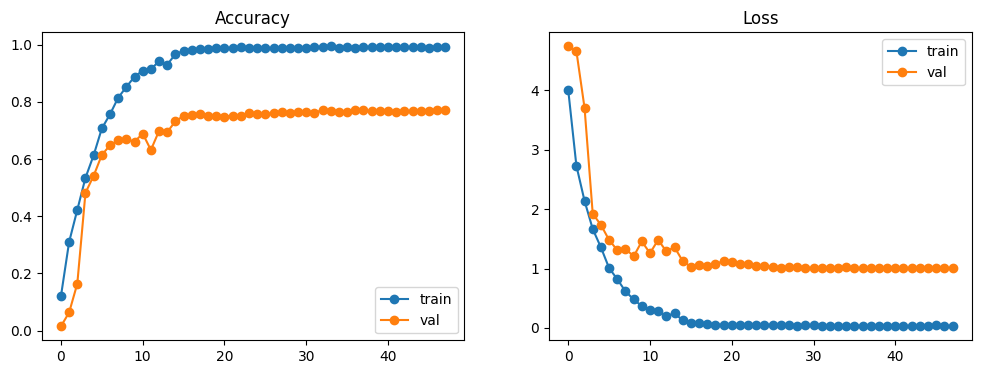

In [14]:
# === 6. Plot metrics ===
def plot_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(hist.history['accuracy'], '-o', label='train')
    ax[0].plot(hist.history['val_accuracy'], '-o', label='val')
    ax[0].set_title('Accuracy')
    ax[0].legend()
    ax[1].plot(hist.history['loss'], '-o', label='train')
    ax[1].plot(hist.history['val_loss'], '-o', label='val')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_history(history)

In [17]:
train_ds, val_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), NoneTensorSpec())>)

In [13]:
# === 7. Evaluate & Confusion Matrix ===
# test_loss, test_acc = model.evaluate(test_ds, verbose=1)
# print(f"Test — loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

# Predict
y_pred = np.argmax(loaded_model.predict(val_ds), axis=1)
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step


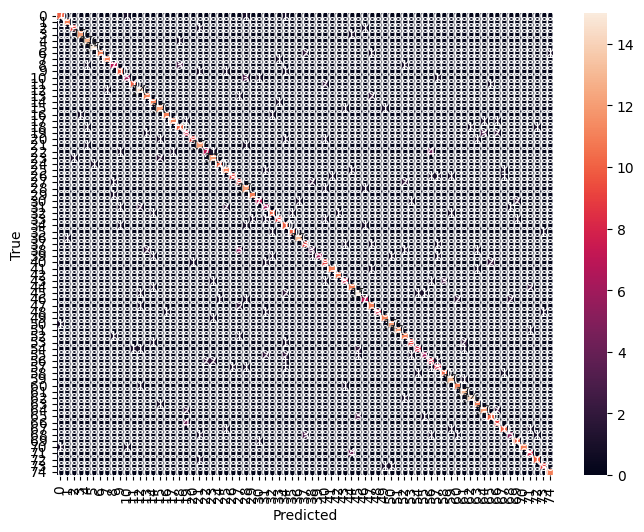

In [19]:
# print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision (macro average for multiclass)
precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision (Macro): {precision:.4f}")

# Calculate recall (macro average for multiclass)
recall = recall_score(y_true, y_pred, average='macro')
print(f"Recall (Macro): {recall:.4f}")

# Calculate F1-score (macro average for multiclass)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1-score (Macro): {f1:.4f}")

# For error rates, we need either the raw prediction probabilities or the labels to be treated as continuous values.
# Since y_true and y_pred are class labels (integers), MSE, RMSE, and MAE applied directly to them
# will measure the average difference in the integer labels. This isn't the typical use case
# for these metrics in classification, but if you want to calculate them:

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f"MSE: {mse:.4f}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse) # or mean_squared_error(y_true, y_pred, squared=False) in newer sklearn
print(f"RMSE: {rmse:.4f}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.4f}")

# Note: Error rates like MSE, RMSE, and MAE are more commonly used in regression tasks
# where the predictions and true values are continuous. Using them directly on class
# labels (especially with a large number of classes) might not always provide the
# most intuitive interpretation of performance for a classification problem.
# The classification_report and confusion matrix are usually the primary metrics
# for classification tasks.

Accuracy: 0.7703
Precision (Macro): 0.7820
Recall (Macro): 0.7700
F1-score (Macro): 0.7688
MSE: 169.2010
RMSE: 13.0077
MAE: 5.2667


In [24]:
np.array(class_names).flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74])

In [45]:
np.array(class_names_og).flatten()

array(['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88',
       'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK',
       'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO',
       'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE',
       'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA',
       'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL',
       'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH',
       'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE',
       'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED',
       'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART',
       'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA',
       'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA',
       'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK',
       'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY',
       'PAPER KITE', 'PEACOCK', 'PINE WHIT

In [44]:
print(classification_report(y_true, y_pred, target_names=class_names_og))

                           precision    recall  f1-score   support

                   ADONIS       0.83      0.77      0.80        13
AFRICAN GIANT SWALLOWTAIL       0.92      1.00      0.96        11
           AMERICAN SNOOT       0.90      0.82      0.86        11
                    AN 88       0.92      0.92      0.92        13
                  APPOLLO       0.81      0.93      0.87        14
                    ATALA       0.94      1.00      0.97        15
 BANDED ORANGE HELICONIAN       1.00      0.73      0.85        15
           BANDED PEACOCK       0.92      0.92      0.92        12
            BECKERS WHITE       0.70      0.58      0.64        12
         BLACK HAIRSTREAK       0.77      0.77      0.77        13
              BLUE MORPHO       0.75      0.55      0.63        11
        BLUE SPOTTED CROW       0.91      0.77      0.83        13
           BROWN SIPROETA       0.70      0.93      0.80        15
            CABBAGE WHITE       0.79      0.79      0.79     

In [ ]:
def predict_single_image(model, img_path, class_names, top_k=3):
    """
    Predict class for a single image and visualize results

    Args:
        model: Trained model
        img_path: Path to image
        class_names: List of class names
        top_k: Number of top predictions to show
    """

    # Load and preprocess image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_probs = predictions[0]

    # Get top-k predictions
    top_indices = np.argsort(predicted_probs)[::-1][:top_k]
    top_probs = predicted_probs[top_indices]
    top_classes = [class_names[i] for i in top_indices]

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Display original image
    ax1.imshow(img_rgb)
    ax1.set_title(f'Input Image\nPredicted: {top_classes[0]}', fontsize=14)
    ax1.axis('off')

    # Display prediction probabilities
    colors = plt.cm.viridis(np.linspace(0, 1, top_k))
    bars = ax2.barh(range(top_k), top_probs, color=colors)
    ax2.set_yticks(range(top_k))
    ax2.set_yticklabels(top_classes)
    ax2.set_xlabel('Probability')
    ax2.set_title(f'Top-{top_k} Predictions')
    ax2.set_xlim(0, 1)

    # Add probability labels
    for i, (bar, prob) in enumerate(zip(bars, top_probs)):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{prob:.3f}', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    return top_classes, top_probs

# Example usage (replace with actual image path)
# Uncomment the following lines after training
# sample_image_path = '/path/to/sample/image.jpg'
# predicted_classes, probabilities = predict_single_image(
#     model, sample_image_path, class_names
# )

In [ ]:
def create_performance_dashboard(history, test_accuracy, test_loss):
    """Create a comprehensive performance dashboard"""

    fig = plt.figure(figsize=(20, 12))

    # Training metrics
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    ax2 = plt.subplot(2, 3, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Final metrics
    ax3 = plt.subplot(2, 3, 3)
    metrics = ['Train Acc', 'Val Acc', 'Test Acc']
    values = [
        history.history['accuracy'][-1],
        history.history['val_accuracy'][-1],
        test_accuracy
    ]
    colors = ['green', 'blue', 'red']
    bars = plt.bar(metrics, values, color=colors, alpha=0.7)
    plt.title('Final Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    # Model complexity
    ax4 = plt.subplot(2, 3, 4)
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = total_params - trainable_params

    sizes = [trainable_params, non_trainable_params]
    labels = ['Trainable', 'Non-Trainable']
    colors = ['lightblue', 'lightcoral']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(f'Model Parameters\nTotal: {total_params:,}')

    # Training time analysis
    ax5 = plt.subplot(2, 3, 5)
    epochs_trained = len(history.history['accuracy'])
    epoch_times = [1] * epochs_trained  # Placeholder - replace with actual times

    plt.plot(range(1, epochs_trained + 1), np.cumsum(epoch_times))
    plt.title('Cumulative Training Time')
    plt.xlabel('Epoch')
    plt.ylabel('Time (arbitrary units)')
    plt.grid(True)

    # Performance summary
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    summary_text = f"""
    ALEXNET PERFORMANCE SUMMARY

    Architecture: 8 Layers (5 Conv + 3 FC)
    Total Parameters: {total_params:,}

    Training Results:
    • Final Training Accuracy: {history.history['accuracy'][-1]:.4f}
    • Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}
    • Test Accuracy: {test_accuracy:.4f}
    • Test Loss: {test_loss:.4f}

    Training Details:
    • Epochs Trained: {epochs_trained}
    • Batch Size: {BATCH_SIZE}
    • Input Size: {IMG_SIZE}×{IMG_SIZE}
    • Classes: {num_classes}

    Key Features:
    • ReLU Activation
    • Dropout Regularization
    • Data Augmentation
    • Batch Normalization
    """

    ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

    plt.tight_layout()
    plt.show()

# Create performance dashboard
# create_performance_dashboard(history, test_accuracy, test_loss)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for model interpretability

    Args:
        img_array: Input image array
        model: Trained model
        last_conv_layer_name: Name of last convolutional layer
        pred_index: Class index to generate heatmap for

    Returns:
        heatmap: Grad-CAM heatmap
    """

    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by how important they are with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 & 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """Display Grad-CAM overlay on original image"""

    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Rescale heatmap to range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((IMG_SIZE, IMG_SIZE))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img.astype('uint8'))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')

    axes[2].imshow(superimposed_img)
    axes[2].set_title('Grad-CAM Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage (uncomment after training)
# sample_image_path = '/path/to/sample/butterfly/image.jpg'
# img_array = preprocess_image_for_gradcam(sample_image_path)
# heatmap = make_gradcam_heatmap(img_array, model, 'conv5')
# display_gradcam(sample_image_path, heatmap)

In [ ]:
def analyze_layer_features(model, sample_image_path):
    """
    Analyze features learned by different layers

    Args:
        model: Trained AlexNet model
        sample_image_path: Path to sample image
    """

    # Load and preprocess image
    img = cv2.imread(sample_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(img / 255.0, axis=0)

    # Define layers to analyze
    conv_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']

    # Create intermediate models
    layer_outputs = []
    for layer_name in conv_layers:
        intermediate_model = Model(
            inputs=model.input,
            outputs=model.get_layer(layer_name).output
        )
        layer_output = intermediate_model.predict(img_array)
        layer_outputs.append((layer_name, layer_output))

    # Visualize feature maps
    fig, axes = plt.subplots(len(conv_layers), 8, figsize=(20, 25))
    fig.suptitle('Feature Maps Across AlexNet Layers', fontsize=16)

    for i, (layer_name, feature_map) in enumerate(layer_outputs):
        for j in range(8):  # Show first 8 feature maps
            ax = axes[i, j]

            # Handle different feature map sizes
            if j < feature_map.shape[-1]:
                ax.imshow(feature_map[0, :, :, j], cmap='viridis')
                if j == 0:
                    ax.set_ylabel(f'{layer_name}\n({feature_map.shape[1]}×{feature_map.shape[2]})',
                                 rotation=0, ha='right', va='center')
            else:
                ax.axis('off')

            ax.set_xticks([])
            ax.set_yticks([])

            if i == 0:
                ax.set_title(f'Filter {j+1}')

    plt.tight_layout()
    plt.show()

    # Feature statistics
    print("Layer-wise Feature Statistics:")
    print("-" * 50)
    for layer_name, feature_map in layer_outputs:
        print(f"{layer_name}:")
        print(f"  Shape: {feature_map.shape}")
        print(f"  Mean activation: {np.mean(feature_map):.4f}")
        print(f"  Std activation: {np.std(feature_map):.4f}")
        print(f"  Sparsity: {np.mean(feature_map == 0):.4f}")
        print()

# Example usage
# analyze_layer_features(model, sample_image_path)

In [ ]:
# /content/kaggle
# /content/kaggle/butterfly-image-classification
# /content/kaggle/butterfly-image-classification/train
# /content/kaggle/butterfly-image-classification/test
# /content/kaggle/butterfly-image-classification/Training_set.csv
# /content/kaggle/butterfly-image-classification/Testing_set.csv

/content/kaggle
/content/kaggle/butterfly-image-classification
/content/kaggle/butterfly-image-classification/train
/content/kaggle/butterfly-image-classification/test
/content/kaggle/butterfly-image-classification/Training_set.csv
/content/kaggle/butterfly-image-classification/Testing_set.csv


In [ ]:
train_dir

'/content/kaggle/butterfly-image-classification/train'